In [1]:
import pyspark
print(pyspark.__version__)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.utils import AnalysisException
from time import sleep
import threading
import os
import io
import torch
import torch.nn.functional as F
from torchvision import transforms
from kafka import KafkaProducer
from PIL import Image
import cv2
import numpy as np
import segmentation_models_pytorch

3.5.0


d:\Anaconda\envs\bigdata\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pyspark.sql import SparkSession

scala_version = '2.12'
spark_version = '3.5.1'
packages = [f'org.apache.spark:spark-sql-kafka-0-10_{scala_version}:{spark_version}', 'org.apache.kafka:kafka-clients:3.7.0']

spark = SparkSession.builder.master("local").appName("kafka-example").config("spark.jars.packages", ",".join(packages)).getOrCreate()

spark

In [3]:
topic_name = 'RandomImage'
kafka_server = 'localhost:9092'



In [4]:
import os
import io
from time import sleep
from kafka import KafkaProducer
from PIL import Image
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import segmentation_models_pytorch
import torch
import torch.nn.functional as F
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
MODEL_LOAD_PATH = f'./models/abhi_sudo_full_2-pretrained_preproc_1-unet+-ep_15-0.01-8.pt'
SAVE_PATH = f'./predictionsKK'

os.makedirs(SAVE_PATH, exist_ok=True)

LOAD_SIZE = 8 # pred generating load size

In [6]:
### UNET CONFIG #########
ENCODER_DEPTH=5
DECODER_CHANNELS=(256, 128, 64, 32, 16)
# BATCH_SIZE= [8, 16, 32, 64, 128]
# LR = [1, 1e-2, 1e-4, 1e-6]
BATCH_SIZE = [8]
LR = [1e-2]
EPOCHS= 50
ENCODER_NAME= 'resnet34'

CLASSES={'Background':0,'Building-flooded':1,'Building-non-flooded':2,'Road-flooded':3,'Road-non-flooded':4,
         'Water':5,'Tree':6,'Vehicle':7,'Pool':8,'Grass':9}
IMG_DIM= 512

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model = segmentation_models_pytorch.Unet(encoder_name=ENCODER_NAME, encoder_depth=ENCODER_DEPTH,
                                          decoder_channels=DECODER_CHANNELS, classes=len(CLASSES))


model = model.to(device)
model.load_state_dict(torch.load(MODEL_LOAD_PATH,map_location=torch.device('cuda')))
# model = model.to("cpu")
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [10]:
 def reverse_transform_mask(inp):
    inp=inp.transpose((1, 2, 0))
    t_mask=np.argmax(inp,axis=2).astype('float32')
    t_mask=cv2.resize(t_mask, dsize=(4000, 3000))
    kernel = np.ones((3,3),np.uint8)
    t_mask = cv2.erode(t_mask, kernel, iterations=1)
    return t_mask

In [11]:
img_dim = 512

In [12]:
def process_image(image_bytes, image_count):
    try:
        print(f"Processing image {image_count}")
        img = Image.open(io.BytesIO(image_bytes))
        img = img.resize((IMG_DIM, IMG_DIM))
        img = np.array(img)
        
        transformed_img = val_transform(img)
        inputs = transformed_img.unsqueeze(0).to(device)

        with torch.no_grad():
            preds = model(inputs)
            preds = torch.sigmoid(preds).cpu().numpy()
            
        f_mask = reverse_transform_mask(preds[0])
        save_path = os.path.join(SAVE_PATH, f'{image_count}.png')
        cv2.imwrite(save_path, f_mask)
        
        print(f"Processed and saved image {image_count} to {save_path}")
    except Exception as e:
        print(f"Error processing image {image_count}: {e}")

In [13]:


view_created = False
view_created_lock = threading.Lock()

In [14]:
def foreach_batch_function(df, epoch_id):
    print(f"Foreach Batch Function called on Epoch ID: {epoch_id}.")
    if df.count() > 0:
        print(f"Processing {df.count()} records in the batch.")
        pandas_df = df.toPandas()
        for index, row in pandas_df.iterrows():
            process_image(row['image_bytes'], row['key'])
    else:
        print("Empty DataFrame received in foreachBatch")

In [15]:
# Create DataFrame from Kafka stream
streamRawDf = spark.readStream.format("kafka").option("kafka.bootstrap.servers", kafka_server).option("subscribe", topic_name).load()
streamDF = streamRawDf.select(col("key").cast("string"), col("value").alias("image_bytes"))

In [16]:
# Start the streaming query
query = streamDF.writeStream.foreachBatch(foreach_batch_function).option("checkpointLocation", "checkpoint_dir").start()
query.awaitTermination()

Foreach Batch Function called on Epoch ID: 268.
Processing 8 records in the batch.
Processing image 6371
Processed and saved image 6371 to ./predictionsKK\6371.png
Processing image 6377
Processed and saved image 6377 to ./predictionsKK\6377.png
Processing image 6383
Processed and saved image 6383 to ./predictionsKK\6383.png
Processing image 6389
Processed and saved image 6389 to ./predictionsKK\6389.png
Processing image 6391
Processed and saved image 6391 to ./predictionsKK\6391.png
Processing image 6394
Processed and saved image 6394 to ./predictionsKK\6394.png
Processing image 6405
Processed and saved image 6405 to ./predictionsKK\6405.png
Processing image 6412
Processed and saved image 6412 to ./predictionsKK\6412.png


(3000, 4000, 3)


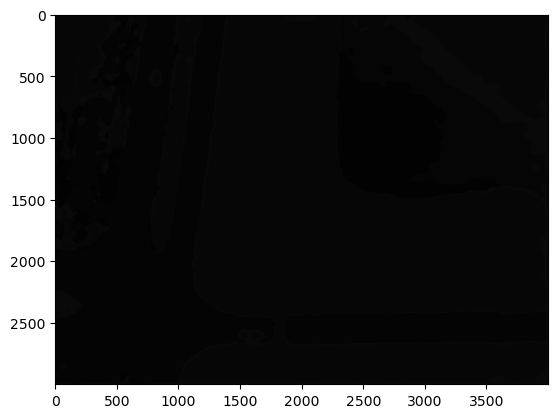

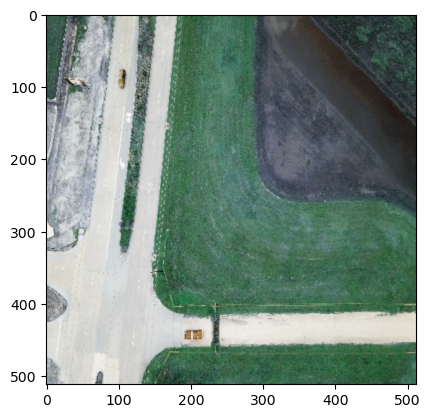

In [ ]:
import cv2
import matplotlib.pyplot as plt

id = 6336
plt.figure()
plt.imshow(cv2.imread(f'predictionsKK/{id}.png'))
print(cv2.imread(f'predictions/{id}.png').shape)
plt.figure()
plt.imshow(cv2.imread(f'./test/image/{id}.jpg'))

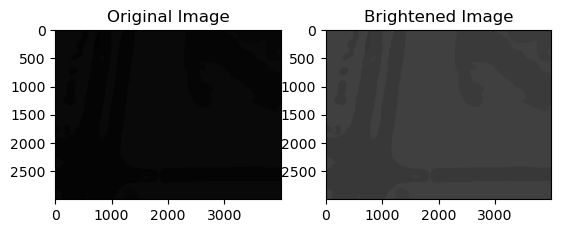

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

id = 6336
image_path = f'./predictions/{id}.png'
image = cv2.imread(image_path)

if image is None:
    raise ValueError(f"The image at path {image_path} could not be loaded. Please check the file path.")

# Tăng độ sáng của ảnh
alpha = 1.5  # Hệ số điều chỉnh độ sáng
beta = 50    # Giá trị tăng thêm độ sáng

bright_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

# Hiển thị ảnh gốc và ảnh tăng độ sáng
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.show()


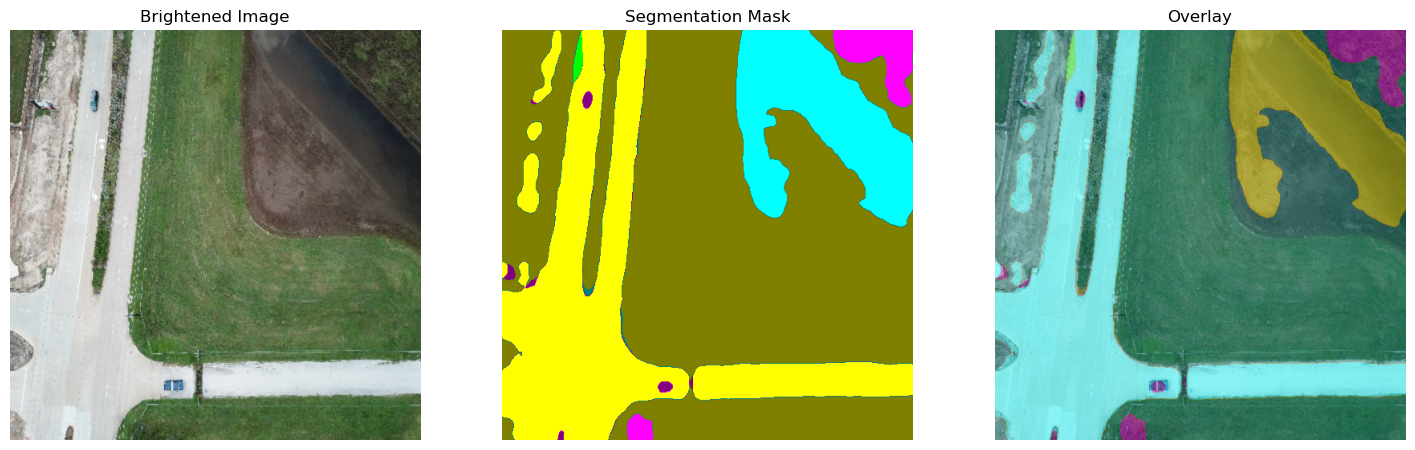

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define the color map for each class (adjust colors as necessary)
COLORS = {
    0: [0, 0, 0],          # Black: Background
    1: [255, 0, 0],        # Red: Building-flooded
    2: [0, 255, 0],        # Green: Building-non-flooded
    3: [0, 0, 255],        # Blue: Road-flooded
    4: [255, 255, 0],      # Yellow: Road-non-flooded
    5: [0, 255, 255],      # Cyan: Water
    6: [255, 0, 255],      # Magenta: Tree
    7: [128, 0, 128],      # Purple: Vehicle
    8: [0, 128, 128],      # Teal: Pool
    9: [128, 128, 0],      # Olive: Grass
}

# Read the predicted segmentation image
id = 6336
segmentation_result_path = f'predictions/{id}.png'
segmentation_result = cv2.imread(segmentation_result_path, cv2.IMREAD_GRAYSCALE)

# Check if the segmentation result was loaded properly
if segmentation_result is None:
    raise FileNotFoundError(f"Segmentation result not found at {segmentation_result_path}")

# Create an RGB image from the grayscale mask
colored_mask = np.zeros((*segmentation_result.shape, 3), dtype=np.uint8)

# Apply colors to the mask
for class_id, color in COLORS.items():
    colored_mask[segmentation_result == class_id] = color

# Load the provided brightened image directly
bright_image_path = f'./test/image/{id}.jpg'  # Change this to your image path if different
bright_image = cv2.imread(bright_image_path)

# Check if the brightened image was loaded properly
if bright_image is None:
    raise FileNotFoundError(f"Brightened image not found at {bright_image_path}")

# Resize the colored mask to match the dimensions of the brightened image
colored_mask_resized = cv2.resize(colored_mask, (bright_image.shape[1], bright_image.shape[0]))

# Blend the brightened original image with the resized colored mask
alpha_blend = 0.6  # Transparency factor for blending
blended_image = cv2.addWeighted(bright_image, alpha_blend, colored_mask_resized, 1 - alpha_blend, 0)

# Display the images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Brightened Image')
plt.imshow(cv2.cvtColor(bright_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Segmentation Mask')
plt.imshow(colored_mask_resized)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Overlay')
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()
